# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "0"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.random_split(
        calibration_ratio, shuffled=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.random_split(calibration_ratio, shuffled=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
detr = DETRModel(model_name="detr_resnet50", pretrained=True)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = detr.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=True,
)
preds_val = detr.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=True,
)

Force recompute is set to True, building predictions...


 15%|█▍        | 5/34 [00:02<00:13,  2.10it/s]

 82%|████████▏ | 28/34 [00:11<00:02,  2.38it/s]

# New Tests

In [ ]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="object",
    matching="assymetric_hausdorff",
    multiple_testing_correction=None,
    confidence_method="nb_boxes",
    localization_method="boxwise",
    localization_prediction_set="additive",
    classification_method="lac",
    optimizer="binary_search",
)

/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[cp.py:1165 -             __init__() ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[cp.py:183 -             __init__() ] Defaulting to CRC backend
[cp.py:856 -             __init__() ] Defaulting to CP backend


In [ ]:
# TODO(leo): we can replace this by anything, doesn't even need a guarantee
conf.calibrate(
    preds_cal,
    alpha_confidence=0.03,
    alpha_localization=0.05,
    alpha_classification=0.05,
)

[cp.py:1395 -            calibrate() ] Calibrating Confidence Conformalizer
  0%|          | 0/13 [00:00<?, ?it/s]

Using assymetric hausdorff distance


2500it [02:05, 19.96it/s]
  0%|          | 0/13 [02:05<?, ?it/s]


AttributeError: 'ConfidenceLoss' object has no attribute 'other_losses'

# 3. Test Conformal Prediction

# Sebastien

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    # objectness_method="box_number",
    # classification_method="lac",
    # multiple_testing_correction="bonferroni",
    confidence_threshold=0.2,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'Confidence' from 'cods.od.loss' (/home/leo.andeol/envs/cods_13/cods/cods/od/loss.py)

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    # localization_method="pixelwise",
    # objectness_method="box_number",
    classification_method="lac",
    # multiple_testing_correction="bonferroni",
    confidence_threshold=0.2,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

Using lbd_plus
Calibrated quantile: 0.9890064597129822
Quantiles
Classification: 0.9890064597129822


100%|██████████| 2500/2500 [00:00<00:00, 3806.89it/s]

Classification:
	 Coverage: 0.89
	 Mean Set Size: 1.23


In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    # objectness_method="box_number",
    confidence_threshold=0.2,
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

[2.20, 2.44] -> [2.3193359375]. Corrected Risk = 0.05: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]


Using lbd_plus
Calibrated quantile: 0.9891996383666992
Quantiles
Localization: 2.3193359375
Classification: 0.9891996383666992


100%|██████████| 2500/2500 [00:06<00:00, 370.08it/s]

Localization:
	 Coverage: 0.95
	 Mean Set Size: 79.13
Classification:
	 Coverage: 0.94
	 Mean Set Size: 39.16
Global:
	 Coverage: 0.92


Using confidence threshold from preds


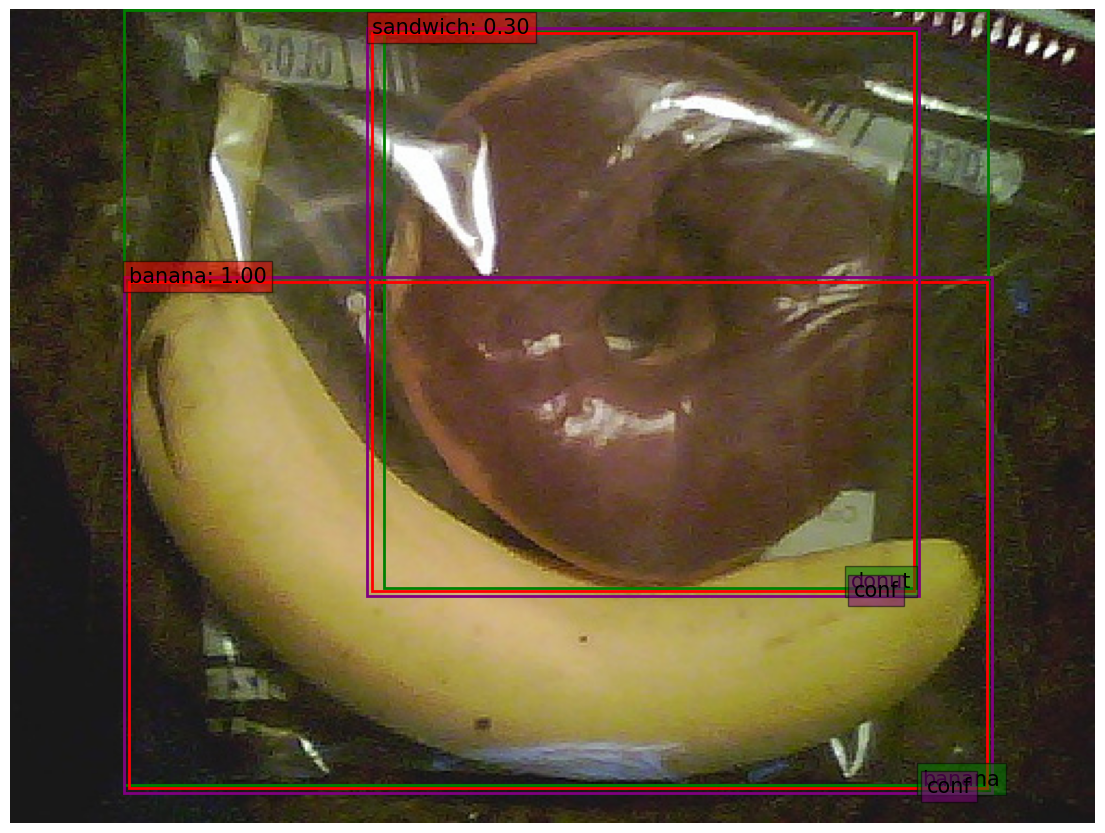

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 1, conf_boxes, conf_cls)

# General

In [ ]:
from cods.od.cp import ODConformalizer

odc = ODConformalizer(
    localization_method="min-hausdorff-additive",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
cal_output = odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

1446it [00:31, 46.01it/s] 


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

RuntimeError: quantile() q must be in the range [0, 1] but got 1.00083

In [ ]:
from cods.od.tr import ODToleranceRegion

odc = ODToleranceRegion(
    localization_loss="pixelwise",
    confidence_loss="box_number",
    classification_loss="lac",
    multiple_testing_correction="bonferroni",
    inequality="bernstein",
)
odc.calibrate(preds_cal, alpha=0.2, delta=0.1, bounds=[0, 1000])
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

TypeError: BinarySearchOptimizer.optimize() got an unexpected keyword argument 'risk_function'

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 10, conf_boxes=conf_boxes, conf_cls=conf_cls)

NameError: name 'preds_val' is not defined

In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(od_preds=preds_val, conf_boxes=conf_boxes, conf_cls=conf_cls)

Defaulting to predictions' confidence threshold


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [01:53<00:00,  2.83s/it]                            


Average Precision: 0.7909144622488076


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]                            

(Conformalist) Average Precision: 0.7702853159101887
